In [104]:
import pandas as pd
from scipy.optimize import minimize
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score
from scipy.stats import norm

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import t

import plotly.subplots as sp
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_excel('data_exam.xlsx', index_col='Unnamed: 0')
df

,VIX,Parkinson,Squared returns
2000-01-04,27.01,0.001406,0.000612
2000-01-05,26.41,0.000002,0.000326
2000-01-06,25.73,0.000045,0.000169
2000-01-07,21.72,0.001577,0.000723
2000-01-10,21.71,0.000109,0.000111
...,...,...,...
2023-02-08,19.63,0.000117,0.000070
2023-02-09,20.71,0.000088,0.000179
2023-02-10,20.53,0.000004,0.000041
2023-02-13,20.34,0.000134,0.000110


### 1. Explain the concept behind each column. What are these time series meant to represent? Transform these time series so that they are comparable in scale and order

- **Le VIX est une mesure de la volatilité attendue des prix des actions du S&P 500. Elle est calculée en fonction des prix des options d'achat et de vente sur cet indice. Le VIX est souvent utilisé comme indicateur de l'état d'anxiété du marché et de la perception des investisseurs quant aux risques à venir.**

- **Le Parkinson est une mesure de la volatilité réalisée des prix des actions. Elle est calculée en fonction des écarts entre les prix les plus élevés et les plus bas sur une période donnée. Cette mesure est plus sensible aux mouvements soudains des prix.**

- **Les rendements au carré, quant à eux, sont une mesure de la volatilité réalisée des prix des actions qui est calculée en prenant les carrés des rendements quotidiens des prix des actions. Cette mesure est souvent utilisée pour évaluer la volatilité des prix des actions sur des périodes plus longues que le Parkinson. Elle est moins sensible aux mouvements brusques des prix et peut être utilisée pour évaluer le risque d'un portefeuille d'investissement.**

### Les trois séries ne sont pas comparable, il faut donc les mettre à la même échelle

In [3]:
# On fait 3 graphiques pour se rendre compte de la différence d'échelle et de l'allure des courbes
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05)

fig.add_trace(go.Scatter(x=df.index, y=df['VIX'], name='VIX'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Parkinson'], name='Parkinson'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['Squared returns'], name='Rendements au carré'), row=3, col=1)

fig.update_yaxes(title_text='VIX', row=1, col=1)
fig.update_yaxes(title_text='Parkinson', row=2, col=1)
fig.update_yaxes(title_text='Rendements au carré', row=3, col=1)
fig.update_xaxes(title_text='Temps', row=3, col=1)

fig.update_layout(height=800, width=800, title={
    'text': "Graphiques financiers",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'})

# Afficher la figure
fig.show()


### les séries Squared returns et Parkinson sont des mesures **intra day**, ce qui explique leur différente echelle et faibles valeurs. On transforme donc ces séries en serie de volatilité annuelle comparable en échelle et en ordre.

In [43]:
# Transformation des series
ann_vol = (df['Squared returns'] ** 0.5) * (252 ** 0.5) * 100
Parkinson_ann = (df['Parkinson'] ** 0.5) * (252 ** 0.5) * 100

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=Parkinson_ann, name='Parkinson annuel'))
fig.add_trace(go.Scatter(x=df.index, y=ann_vol, name='Volatilité annuelle'))
fig.add_trace(go.Scatter(x=df.index, y=df['VIX'], name='VIX'))

fig.update_layout(title='Indicateurs de volatilité', xaxis_title='Temps', yaxis_title='Volatilité',
                  legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))

fig.show()


### 2. Estimate and AR model on each of these time series. Determine the order of the AR process and show the estimates. What can you conclude from these estimations

#### Avant d'estimer un AR(p) il faut faire un test de stationnarité pour savoir s'il y a des transformations à faire

# Test de stationnarité

In [44]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Fonction du test augmented dickey fuller
def dickey(series, nom_de_la_serie:str):
    result = adfuller(series)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    #  H0 : la série n'est pas stationnaire donc si p < 0.05 on rejette H0
    if result[1] > 0.05:
        print(f'La série {nom_de_la_serie} n\'est pas stationnaire.')
    else:
        print(f'La série {nom_de_la_serie} est stationnaire.')


## Les 3 séries sont stationnaires il faut donc se référer au PACF

In [45]:
dickey(df['VIX'], 'VIX')
print('#'*30)
dickey(Parkinson_ann, 'Parkinson')
print('#'*30)
dickey(ann_vol, 'returns')

ADF Statistic: -5.742412
p-value: 0.000001
La série VIX est stationnaire.
##############################
ADF Statistic: -7.314537
p-value: 0.000000
La série Parkinson est stationnaire.
##############################
ADF Statistic: -6.800695
p-value: 0.000000
La série returns est stationnaire.


#### On regarde ensuite si ce sont des séries additives ou multiplicatives pour plusieurs raisons :

- **Prévision** : Si la série est additive, les prévisions sont souvent plus simples, car on peut simplement extrapoler les tendances précédentes en utilisant des méthodes de régression linéaire. Si la série est multiplicative, il faut tenir compte de la croissance exponentielle, ce qui peut rendre les prévisions plus complexes.
- **Modélisation** : Comprendre si une série est additive ou multiplicative est important pour choisir le bon modèle. Par exemple, si la série est additive, on peut utiliser un modèle de régression linéaire, tandis que si la série est multiplicative, un modèle de régression non linéaire peut être plus approprié.
- **Interprétation des résultats**: La signification des résultats peut être différente selon que la série est additive ou multiplicative. Par exemple, dans le cas d'une augmentation de pourcentage dans une série multiplicative, une augmentation de 10 % peut être significativement différente d'une augmentation de 20 %, tandis que dans une série additive, une augmentation de 10 unités est toujours une augmentation de 10 unités.

### Les trois séries sont additive car la saisonalité garde la même magnitude à travers le temps

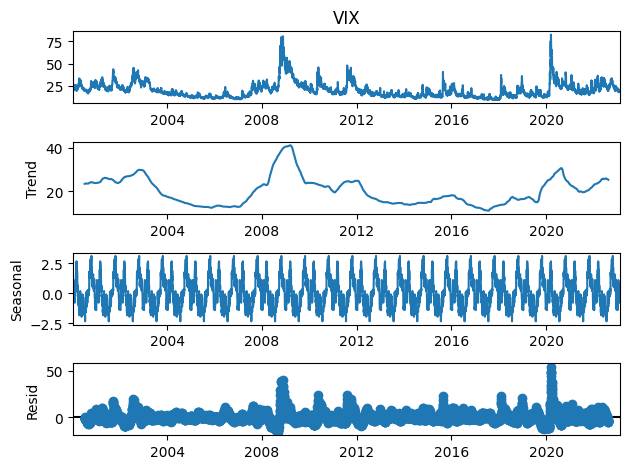

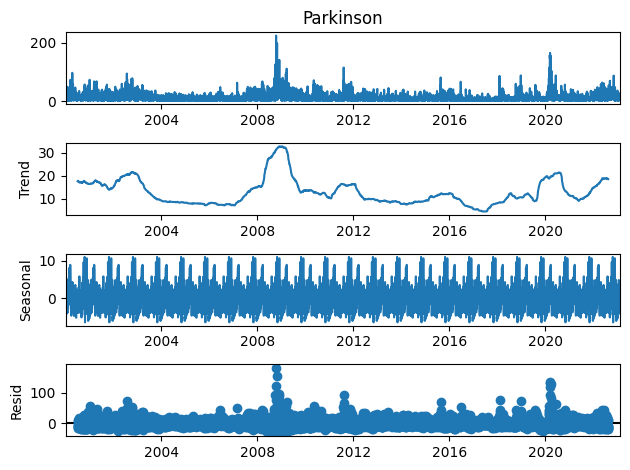

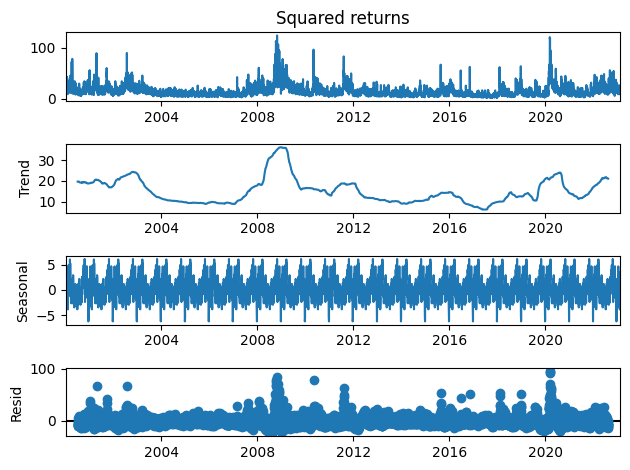

In [46]:
for series in [df['VIX'], Parkinson_ann, ann_vol]:
    seasonal_decompose(series, model="additive", period=252).plot()


### Les 3 séries sont additives donc pas besoin de faire transformation particulières

# Determine the order of the AR process and show the estimates.

##### Pour determiner l'ordre de l'AR on utilise le PACF

# PACF

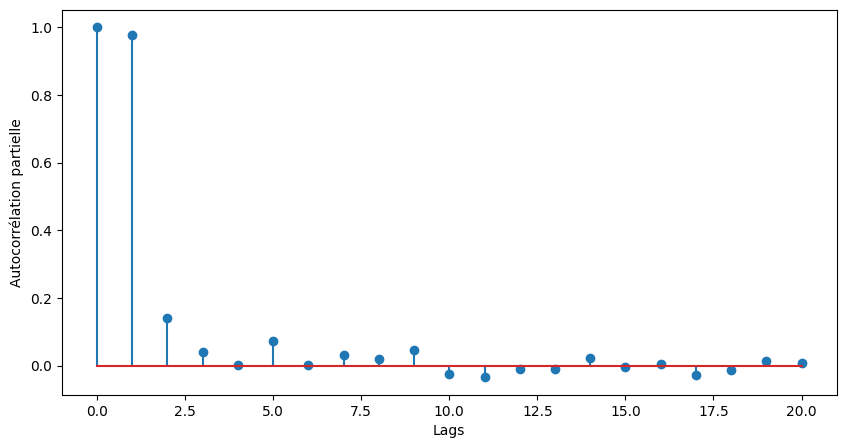

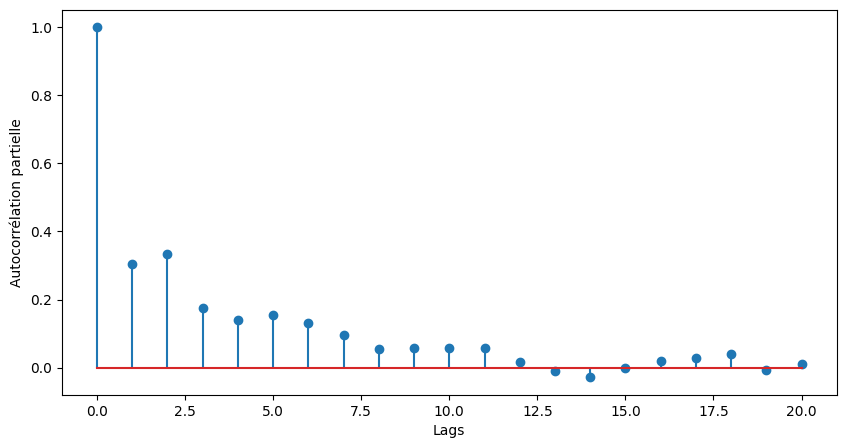

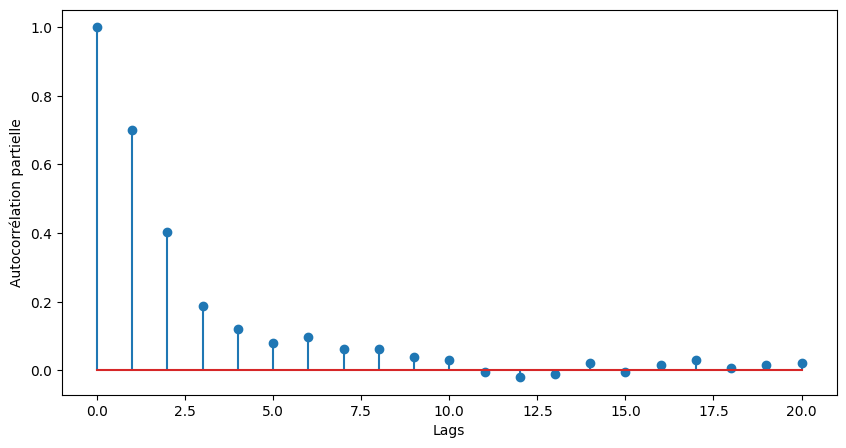

Lag optimal pour la série VIX: 4
Lag optimal pour la série Parkinson: 12
Lag optimal pour la série Squared returns: 11


In [47]:
series1 = df['VIX']
series2 = Parkinson_ann
series3 = ann_vol


# Fonction pour déterminer le bon Lag d'une série
def find_best_lag(series):
    # On calcule le PACF de la série et on affiche 20 lags
    pacf = sm.tsa.stattools.pacf(series, nlags=20, method='ols')
    
    # On trace le PACF
    plt.figure(figsize=(10, 5))
    plt.stem(pacf)
    plt.xlabel('Lags')
    plt.ylabel('Autocorrélation partielle')
    plt.show()
    
    # On retient le premier lag où l'autocorrélation partielle est inférieure à la limite de confiance
    # (définie ici comme 2/sqrt(n), où n est la longueur de la série)
    n = len(series)
    conf_limit = 2 / np.sqrt(n)
    for i in range(len(pacf)):
        if pacf[i] < conf_limit:
            return i
    
    # Si aucun lag ne convient, retourner le nombre de lags maximum
    return 20

# Trouver le bon Lag pour chaque série
lag1 = find_best_lag(series1)
lag2 = find_best_lag(series2)
lag3 = find_best_lag(series3)

# Afficher les résultats
print('Lag optimal pour la série VIX: {}'.format(lag1))
print('Lag optimal pour la série Parkinson: {}'.format(lag2))
print('Lag optimal pour la série Squared returns: {}'.format(lag3))


## Estimate and AR model on each of these time series.

In [122]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# On définit une fonction qui prend en entrée des paramètres initiaux, une série, un nombre de lags chosis auparavant
# à l'ai du PACF
def ML_criterion_arp(para, x, lags, plot=False):
    """
    Fonction qui calcule la log-vraisemblance négative pour un modèle autorégressif d'ordre p (AR(p)).

    Parameters
    ----------
    para : numpy.ndarray
        Un vecteur de taille p+1 contenant les paramètres du modèle, où p est le nombre de lags.
        Le premier élément correspond à la constante, les autres aux coefficients associés aux lags.
    x : pandas.Series
        Une série temporelle de taille n, où n est le nombre d'observations.
    lags : list
        Une liste des lags à inclure dans le modèle.
    plot : bool, optional
        Si True, la fonction affichera un graphique de la série initiale et de la série ajustée.

    Returns
    -------
    float
        La log-vraisemblance négative du modèle AR(p) ajusté aux données x.

    """
    expected = para[0] # Correspond au paramètre x0
    for i, lag in enumerate(lags):
        expected += para[i+1]*x.shift(lag) # On ajoute autant de paramètres et de lags que spécifier en entrée ce qui rend l'écriture moins fastidieuse
    expected = expected.dropna()
    difference = x.iloc[lags[-1]:] - expected
    volatility = np.nanstd(difference)
    loglik = norm.pdf(x.iloc[lags[-1]:], expected, volatility)
    criterion = np.nansum(np.log(loglik))
    if plot:
        temp = pd.concat([x, expected], axis=1)
        temp.columns = ['initial', 'fit']
        temp = temp.dropna()
        temp.plot()
    return -criterion # On retourne la log vraisemblance négativement pour la minimiser ce qui revient à maximiser son inverse


def get_lags(signif_lags, p):

    return [i for i in range(1, p+1) if i not in signif_lags]

def backward(x, p, alpha=0.05):
    """
    Effectue une sélection de modèle en utilisant une méthode backward
    x : une série temporelle
    p : ordre maximal de l'AR à tester
    alpha : seuil de significativité du test de Student (par défaut 0.05)
    """
    # liste des lags significatifs
    # A chaque itération si une paramètre n'est pas significatif il est retiré
    signif_lags = list(range(1, p+1))
    
    while True:
        # On ajuste le modèle avec les lags actuels
        para0 = np.random.uniform(low=-10, high=10, size=len(signif_lags)+1)
        res_AR = minimize(ML_criterion_arp, para0, method='BFGS', args=(x, signif_lags), options={'disp': False})

        # test de Student pour sélectionner les lags significatifs
        std_para = np.diag(res_AR.hess_inv)**.5
        tstats = res_AR.x/std_para
        max_tstat = np.abs(tstats[1:]).min()
        if max_tstat < norm.ppf(1-alpha/2):
            # si le lag le moins significatif n'est pas significatif
            # retirer le lag correspondant
            lag_to_remove = signif_lags[np.abs(tstats[1:]).argmin()]
            signif_lags.remove(lag_to_remove)
        else:
            # tous les lags restants sont significatifs
            break
    
    # ajuster le modèle avec les lags sélectionnés
    para0 = np.random.uniform(low=-10, high=10, size=len(signif_lags)+1)
    res_AR = minimize(ML_criterion_arp, para0, method='BFGS', args=(x, signif_lags), options={'disp': False})
    std_param =np.diag(res_AR.hess_inv)**.5
    student_test = res_AR.x/std_para
    return res_AR.x, signif_lags, res_AR.fun, std_param, student_test

# Exemple des sorties de la fonction que nous allons mettre en forme
p = 12
res_AR_x, signif_lags, res_AR_fun, std_param, student_test = backward(Parkinson_ann, p=p)
print("Lags significatifs :", signif_lags)
print("MLE :", res_AR_fun)
print("Paramètres optimaux : ",res_AR_x)
print('Std param : ', std_param)
print("Student test : ", student_test)

Lags significatifs : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
MLE : 22974.15882509276
Paramètres optimaux :  [2.23291038 0.04877961 0.18517283 0.0697123  0.05904327 0.09900285
 0.09994008 0.0749163  0.03645396 0.04239841 0.05507098 0.05834115]
Std param :  [0.28291852 0.01337626 0.01336163 0.0143969  0.01382834 0.01414704
 0.01367834 0.01350851 0.01364007 0.01264835 0.01326417 0.01320267]
Student test :  [ 8.88921302  3.73261917 15.93849189  5.76260935  4.95994488  8.04484949
  7.92924498  5.5043494   3.21210411  3.43632484  4.0261235   4.61600519]


In [123]:
def get_residual_variance(para_opt, x, lags):
    """
    Calcule la variance résiduelle à partir des paramètres optimaux d'un modèle AR(p)

    Parameters
    ----------
    para_opt : numpy.ndarray
        Un vecteur de taille p+1 contenant les paramètres optimaux du modèle AR(p), où p est le nombre de lags.
        Le premier élément correspond à la constante, les autres aux coefficients associés aux lags.
    x : pandas.Series
        Une série temporelle de taille n, où n est le nombre d'observations.
    lags : list
        Une liste des lags à inclure dans le modèle.

    Returns
    -------
    float
        La variance résiduelle du modèle AR(p) ajusté aux données x.

    """
    # Prédiction des valeurs ajustées de la série temporelle
    expected = para_opt[0]
    for i, lag in enumerate(lags):
        expected += para_opt[i+1]*x.shift(lag)
    expected = expected.dropna()

    # Calcul des résidus
    residuals = x.iloc[lags[-1]:] - expected

    # Calcul de la variance résiduelle
    residual_variance = np.var(residuals)

    return residual_variance, expected

# Série Parkinson

### On peut s'assurer que l'AR(11) est le plus adapté car sa variance résiduelle est la moins élevé

In [124]:
my_list = []

for i in range(1, 12):
    # votre code ici
    my_list.append(i)
    residual_variance, expected = get_residual_variance(res_AR_x, Parkinson_ann, my_list)
    
    # mettre à jour la première valeur de la liste avec la valeur de la dernière itération
    print("Lags compris dans le modèle :", my_list)
    print("Variance résiduel : ", residual_variance)

Lags compris dans le modèle : [1]
Variance résiduel :  215.92089956218277
Lags compris dans le modèle : [1, 2]
Variance résiduel :  192.2193719748052
Lags compris dans le modèle : [1, 2, 3]
Variance résiduel :  185.61712081730343
Lags compris dans le modèle : [1, 2, 3, 4]
Variance résiduel :  180.30311321752913
Lags compris dans le modèle : [1, 2, 3, 4, 5]
Variance résiduel :  172.6766837319362
Lags compris dans le modèle : [1, 2, 3, 4, 5, 6]
Variance résiduel :  166.55840596625788
Lags compris dans le modèle : [1, 2, 3, 4, 5, 6, 7]
Variance résiduel :  163.1936925373538
Lags compris dans le modèle : [1, 2, 3, 4, 5, 6, 7, 8]
Variance résiduel :  162.05434331467296
Lags compris dans le modèle : [1, 2, 3, 4, 5, 6, 7, 8, 9]
Variance résiduel :  160.93684756585105
Lags compris dans le modèle : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Variance résiduel :  159.84401677718265
Lags compris dans le modèle : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Variance résiduel :  159.05505341295364


### On créer des tables pour résumer les résultats comme statsmodels

#### Tout les coefficients sont significatifs

In [93]:
from scipy.stats import t

results_summary = pd.DataFrame({
    'Lags': signif_lags,
    'Coefficient': res_AR_x[1:],
    'Std. Error': std_param[1:],
    't': student_test[1:],
    'P>|t|': 2 * (1 - t.cdf(np.abs(student_test[1:]), len(Parkinson_ann) - len(res_AR_x)))
})

# Ajouter la ligne pour la constante
results_summary.loc[len(results_summary)] = ['const', res_AR_x[0], std_param[:1][0],student_test[:1][0], 2 * (1 - t.cdf(np.abs(student_test[:1]), len(Parkinson_ann) - len(res_AR_x)))[0]]
print(" Log Likelihood :", res_AR_fun)


r2 = r2_score(Parkinson_ann[11:], expected)
print("Coefficient de détermination R² : ", r2)

print(results_summary.to_string(index=False))


 Log Likelihood : 22974.15882509273
Coefficient de détermination R² :  0.28305328300341914
 Lags  Coefficient  Std. Error             t    P>|t|
    1     0.048780    0.019955      3.736047 0.000189
    2     0.185173    0.012250 642063.279767 0.000000
    3     0.069712    0.008739      2.928873 0.003415
    4     0.059043    0.016490      4.301193 0.000017
    5     0.099003    0.020890      3.434654 0.000597
    6     0.099940    0.017670      4.393402 0.000011
    7     0.074916    0.017547      4.874205 0.000001
    8     0.036454    0.015326      2.577520 0.009976
    9     0.042398    0.013476      2.220789 0.026404
   10     0.055071    0.025722      3.290463 0.001006
   11     0.058341    0.017222      4.403768 0.000011
const     2.232920    0.607071     13.841628 0.000000


#### Interprétation
**Nous avons un AR avec 11 paramètres significatifs + 1 constante et une variance expliqué d'environ 28% par l'AR ce qui est relativement élevé**

# Série VIX

In [127]:
p = 4
res_AR_x, signif_lags, res_AR_fun, std_param, student_test = backward(df['VIX'], p=p)

my_list = []

for i in range(1, 4):
    # votre code ici
    my_list.append(i)
    residual_variance, expected = get_residual_variance(res_AR_x, df['VIX'], my_list)
    
    # mettre à jour la première valeur de la liste avec la valeur de la dernière itération
    print("Lags compris dans le modèle :", my_list)
    print("Variance résiduel : ", residual_variance)

Lags compris dans le modèle : [1]
Variance résiduel :  4.775929561943273
Lags compris dans le modèle : [1, 2]
Variance résiduel :  3.3089230548893185
Lags compris dans le modèle : [1, 2, 3]
Variance résiduel :  3.187346232984241


In [113]:

results_summary = pd.DataFrame({
    'Lags': signif_lags,
    'Coefficient': res_AR_x[1:],
    'Std. Error': std_param[1:],
    't': student_test[1:],
    'P>|t|': 2 * (1 - t.cdf(np.abs(student_test[1:]), len(df['VIX']) - len(res_AR_x)))
})

# Ajouter la ligne pour la constante
results_summary.loc[len(results_summary)] = ['const', res_AR_x[0], std_param[:1][0],student_test[:1][0], 2 * (1 - t.cdf(np.abs(student_test[:1]), len(Parkinson_ann) - len(res_AR_x)))[0]]
print(" Log Likelihood :", res_AR_fun)


r2 = r2_score(df['VIX'][3:], expected)
print("Coefficient de détermination R² : ", r2)

print(results_summary.to_string(index=False))

 Log Likelihood : 11629.462756267369
Coefficient de détermination R² :  0.9576492910818553
 Lags  Coefficient  Std. Error         t        P>|t|
    1     0.835916    0.013168 62.703384 0.000000e+00
    2     0.105706    0.017499  7.950654 2.220446e-15
    3     0.040277    0.013530 38.872758 0.000000e+00
const     0.364082    0.062081  2.886492 3.909965e-03


#### Interprétation
**Nous avons un AR avec 3 paramètres significatifs + 1 constante dont le premier qui a une grande importance et une variance expliqué d'environ 95% par l'AR ce qui est relativement élevé**

# Série Squared returns

In [129]:
p = 11
res_AR_x, signif_lags, res_AR_fun, std_param, student_test = backward(ann_vol, p=p)

my_list = []

for i in [1, 2, 3, 4, 6, 7, 9]:
    my_list.append(i)
    residual_variance, expected = get_residual_variance(res_AR_x, ann_vol, my_list)
    
    print("Lags compris dans le modèle :", my_list)
    print("Variance résiduel : ", residual_variance)

Lags compris dans le modèle : [1]
Variance résiduel :  89.40295630404849
Lags compris dans le modèle : [1, 2]
Variance résiduel :  64.66583134424663
Lags compris dans le modèle : [1, 2, 3]
Variance résiduel :  58.562312680489015
Lags compris dans le modèle : [1, 2, 3, 4]
Variance résiduel :  55.95752920396364
Lags compris dans le modèle : [1, 2, 3, 4, 6]
Variance résiduel :  53.73982084282242
Lags compris dans le modèle : [1, 2, 3, 4, 6, 7]
Variance résiduel :  52.897190951618
Lags compris dans le modèle : [1, 2, 3, 4, 6, 7, 9]
Variance résiduel :  52.37395858041633


In [119]:
results_summary = pd.DataFrame({
    'Lags': signif_lags,
    'Coefficient': res_AR_x[1:],
    'Std. Error': std_param[1:],
    't': student_test[1:],
    'P>|t|': 2 * (1 - t.cdf(np.abs(student_test[1:]), len(ann_vol) - len(res_AR_x)))
})

# Ajouter la ligne pour la constante
results_summary.loc[len(results_summary)] = ['const', res_AR_x[0], std_param[:1][0],student_test[:1][0], 2 * (1 - t.cdf(np.abs(student_test[:1]), len(Parkinson_ann) - len(res_AR_x)))[0]]
print(" Log Likelihood :", res_AR_fun)


r2 = r2_score(ann_vol[9:], expected)
print("Coefficient de détermination R² : ", r2)

print(results_summary.to_string(index=False))

 Log Likelihood : 19735.377272076796
Coefficient de détermination R² :  0.6018875738263005
 Lags  Coefficient  Std. Error         t        P>|t|
    1     0.292376    0.013290 22.616902 0.000000e+00
    2     0.255396    0.012390 19.058776 0.000000e+00
    3     0.106914    0.013161  8.113660 6.661338e-16
    4     0.059714    0.014170  4.389205 1.157803e-05
    6     0.065093    0.014125  7.260413 4.365397e-13
    7     0.040454    0.012987  3.285287 1.024820e-03
    8     0.051666    0.014512  5.509700 3.748890e-08
   10     0.039408    0.012655  2.895282 3.802295e-03
const     1.359750    0.218780 13.138352 0.000000e+00


#### Interprétation
**Nous avons un AR avec 10 paramètres + 1 constante significatifs dont le premier qui a une grande importance et une variance expliqué d'environ 60% par l'AR ce qui est relativement élevé**

# Question 3 : Plot the fitted values for each model vs. the original time series. Why are these fitted values appealing for volatility measuring purposes?

**Les valeurs ajustées sont intéressantes pour mesurer la volatilité, car elles représentent la moyenne ou la tendance estimée de la série temporelle. En soustrayant les valeurs ajustées de la série temporelle originale, vous pouvez obtenir les résidus, qui représentent la partie non expliquée ou imprévisible de la série temporelle. Les résidus peuvent être utilisés pour estimer la volatilité de la série temporelle, qui est une mesure de la quantité de fluctuation ou de variation des données. Le modèle AR peut être utilisé pour estimer la volatilité de la série temporelle en modélisant la variance conditionnelle des résidus, qui est une fonction des valeurs retardées des résidus. En utilisant les valeurs ajustées et les résidus ensemble, vous pouvez estimer la volatilité de la série temporelle et faire des prévisions sur la volatilité future.** 

# Parkinson

<Axes: >

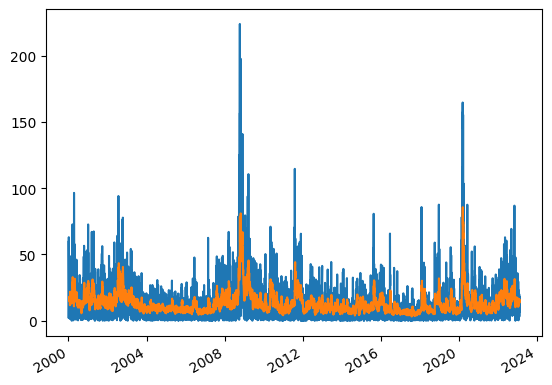

In [126]:
Parkinson_ann.plot()
expected.plot()

# VIX

<Axes: >

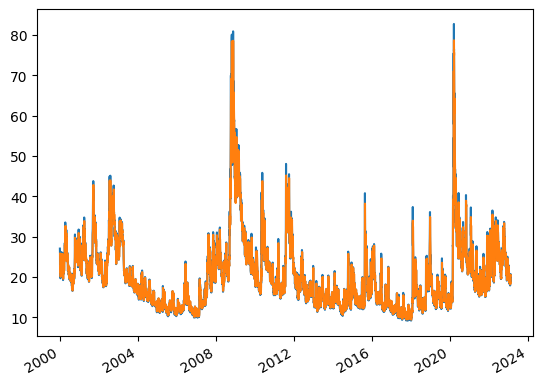

In [128]:
df['VIX'].plot()
expected.plot()

# Squared returns

<Axes: >

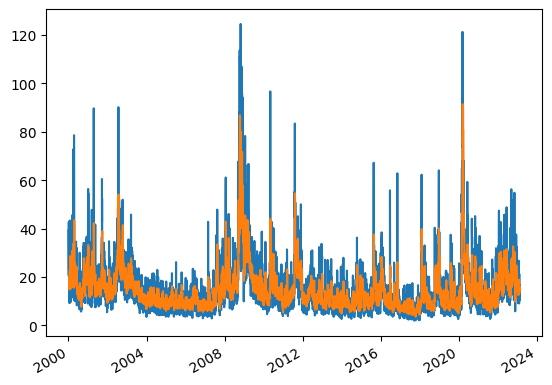

In [131]:
ann_vol.plot()
expected.plot()

# Question 4 : Estimate an HAR model on each time series. Present the estimated coefficients of the model and compare the loglikelihood of each model to the one obtained from the AR estimations. Which model do you prefer? (4 points). Retain the fitted values of the model you have selected for each of the three time series.

### Il faut choisir le modèle en se basant sur le maximum de vraisemblance et des critères d'information

# HAR modèle

In [132]:
# Optimization
from scipy.stats import norm

def ML_HAR(para,x,plot=False):
    phi0=para[0]
    phi1=para[1]
    phi2=para[2]
    phi3=para[3]
    
    # computing moving averages
    ma5=x.rolling(5).mean().shift(1)
    ma22=x.rolling(22).mean().shift(1)
    ma1=x.shift(1)

    combination=pd.concat([x, ma1, ma5, ma22],axis=1)
    combination=np.log(combination+ 1) # On travail avec le log de la variance journalière
    # On ajoute 1 à la formule pour eviter log(0)
    combination=combination.dropna()
    combination.columns=['ini','ma1', 'ma5', 'ma22']   
    

    expected=phi0+phi1*combination['ma1']+phi2*combination['ma5']+phi3*combination['ma22']
    temp=pd.concat([combination['ini'],expected],axis=1)
    error=combination['ini']-expected
    sigma=np.nanstd(error)
    #print(para)
    density=norm.pdf(combination['ini'],expected,sigma)
    criterion=np.nansum(np.log(density))
    if plot==True:
        #temp.exp(x**2)(data**.5)*(250**.5)*100
        #Parkinson_ann=(df['Parkinson']**.5)*(252**.5)*100
        #temp = np.log(temp)
        
        temp.plot()
    return -criterion

# VIX Series

In [138]:
res_EV_VIX_HAR = minimize(ML_HAR, np.random.uniform(low=-10, high=10, size=4), method='BFGS', args=(df['VIX']),options={'disp': False})
HAR_param_vix = res_EV_VIX_HAR.x
std_param =np.diag(res_EV_VIX_HAR.hess_inv)**.5
student_test = HAR_param_vix/std_param

print("coefficient estimé du modèle:", HAR_param_vix)
print("test de student :",student_test)

coefficient estimé du modèle: [0.03820209 0.89003269 0.06168079 0.03538413]
test de student : [ 4.82924475 66.72581127  3.61519275  3.88336358]


### Tous les coefficients sont significatifs et la première moyenne mobile a un grand impact sur l'estimation du fait de la valeur de son coefficient

-7472.97411505163

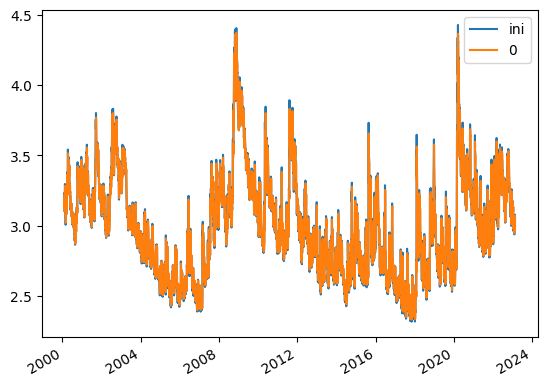

In [134]:
ML_HAR(HAR_param_vix, df['VIX'], plot=True)

# Serie Squared returns

In [139]:
res_EV = minimize(ML_HAR, np.random.uniform(low=-10, high=10, size=4), method='BFGS', args=(ann_vol),options={'disp': False})
HAR_param = res_EV.x
std_param =np.diag(res_EV.hess_inv)**.5
student_test = HAR_param/std_param

print("coefficient estimé du modèle:", HAR_param)
print("test de student :",student_test)

coefficient estimé du modèle: [0.16721601 0.14299342 0.54123921 0.23692909]
test de student : [10.68406792 12.08712451 53.03009999 18.61270697]


### Tous les coefficients sont significatifs et le coefficient de la deuxième moyenne mobile correspondant à 5 jours à un impact relativement élevé

2437.8906003381744

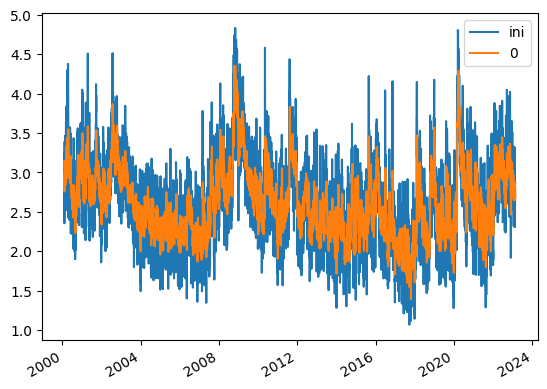

In [43]:
ML_HAR(res_EV.x, ann_vol, plot=True)

# Serie parkinson

In [140]:
res_EV = minimize(ML_HAR, np.random.uniform(low=-10, high=10, size=4), method='BFGS', args=(Parkinson_ann),options={'disp': False})
HAR_param = res_EV.x
std_param =np.diag(res_EV.hess_inv)**.5
student_test = HAR_param/std_param

print("coefficient estimé du modèle:", HAR_param)
print("test de student :",student_test)

coefficient estimé du modèle: [ 0.21910789 -0.03945597  0.37904195  0.45367025]
test de student : [ 3.59689678 -2.61481196 10.19315691 11.30300115]


### Tous les coefficients sont significatifs et le coefficient de la troisième moyenne mobile correspondant à 22 jours à un impact relativement élevé

### Conclusion final pour le modèle HAR
**Le modèle HAR semble traduire les stratégies/caractère court, moyen et long terme que représente l'étude de ces trois series**

7518.204480780162

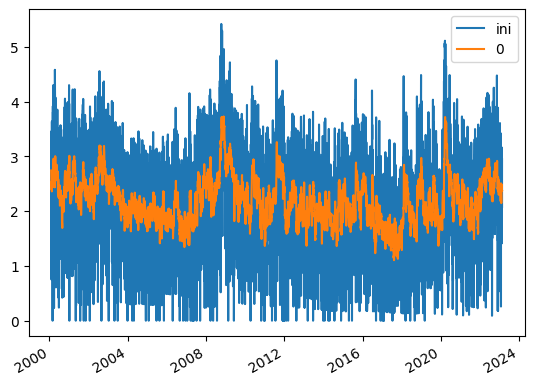

In [45]:
ML_HAR(res_EV.x, Parkinson_ann, plot=True)

In [147]:
import numpy as np

def compute_aic_bic(ll, n_params, n_obs):
    """
    Compute AIC and BIC criteria for model selection.
    ll: maximum likelihood value
    n_params: number of estimated parameters
    n_obs: number of observations
    """
    aic = -2 * ll + 2 * n_params
    bic = -2 * ll + n_params * np.log(n_obs)
    return aic, bic


# Pour Parkinson HAR est meilleur que l'AR

In [ ]:
aic, bic = compute_aic_bic(-ML_HAR(res_EV.x, Parkinson_ann, plot=False), 4, len(Parkinson_ann))
print(aic, bic)

15044.408961560363 15071.086558057585


In [148]:
p = 12
res_AR_x, signif_lags, res_AR_fun, std_param, student_test = backward(Parkinson_ann, p=p)
aic, bic = compute_aic_bic(-res_AR_fun, 11, len(Parkinson_ann))
print(aic, bic)


45970.31765018615 46043.681040553514


# Pour Squared returns HAR est meilleur que l'AR

In [ ]:
aic, bic = compute_aic_bic(-ML_HAR(res_EV.x, ann_vol, plot=False), 4, len(ann_vol))
print(aic, bic)

4883.781200676354 4910.458797173576


In [149]:
p = 11
res_AR_x, signif_lags, res_AR_fun, std_param, student_test = backward(ann_vol, p=p)
aic, bic = compute_aic_bic(-res_AR_fun, 8, len(ann_vol))
print(aic, bic)

39481.00609940145 39534.36129239589


# Pour VIX HAR est meilleur que l'AR

In [ ]:
aic, bic = compute_aic_bic(ML_HAR(res_EV.x, df['VIX'], plot=False), 4, len(df['VIX']))
print(aic, bic)

8294.16567563922 8320.843272136442


In [150]:
p = 4
res_AR_x, signif_lags, res_AR_fun, std_param, student_test = backward(df['VIX'], p=p)
aic, bic = compute_aic_bic(-res_AR_fun, 2, len(ann_vol))
print(aic, bic)

23262.92551253487 23276.264310783485


# Question 5

In [153]:
import numpy as np
from scipy.optimize import minimize

def optimize_ML_HAR(x, plot=False):
    
    def ML_HAR(para,x):
        phi0=para[0]
        phi1=para[1]
        phi2=para[2]
        phi3=para[3]

        # computing moving averages
        ma5=x.rolling(5).mean().shift(1)
        ma22=x.rolling(22).mean().shift(1)
        ma1=x.shift(1)

        combination=pd.concat([x, ma1, ma5, ma22],axis=1)
        combination=np.log(combination+ 1) # On travail avec le log de la variance journalière
        combination=combination.dropna()
        combination.columns=['ini','ma1', 'ma5', 'ma22']   

        expected=phi0+phi1*combination['ma1']+phi2*combination['ma5']+phi3*combination['ma22']
        temp=pd.concat([combination['ini'],expected],axis=1)
        error=combination['ini']-expected
        sigma=np.nanstd(error)
        density=norm.pdf(combination['ini'],expected,sigma)
        criterion=np.nansum(np.log(density))
        return -criterion
    
    # initial guess for parameters
    para0 = np.array([0, 0, 0, 0])
    
    # minimize negative log-likelihood using Nelder-Mead algorithm
    result = minimize(ML_HAR, para0, args=(x,), method='Nelder-Mead')
    
    # extract optimized parameter values
    para_opt = result.x
    
    # compute temp using optimized parameters
    expected_opt = para_opt[0] + para_opt[1]*x.shift(1).rolling(5).mean().shift(1) + para_opt[2]*x.shift(1).rolling(22).mean().shift(1) + para_opt[3]*x.rolling(22).mean().shift(1)
    temp_opt = pd.concat([x, expected_opt], axis=1)
    
    if plot:
        temp_opt.plot()
    
    # compute criterion using optimized parameters
    criterion_opt = -ML_HAR(para_opt, x)
    
    # return optimized parameter values, criterion, and temp
    return para_opt, criterion_opt, temp_opt


In [154]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

def compute_fitted_values(x):
    """
    Computes the fitted values for the HAR model using maximum likelihood estimation
    
    Parameters:
    - x : pandas Series
        Daily log-returns of an asset
    
    Returns:
    - pandas DataFrame
        Dataframe containing the original log-returns and the fitted values
    """
    
    def ML_HAR(para,x):
        phi0=para[0]
        phi1=para[1]
        phi2=para[2]
        phi3=para[3]

        # computing moving averages
        ma5=x.rolling(5).mean().shift(1)
        ma22=x.rolling(22).mean().shift(1)
        ma1=x.shift(1)

        combination=pd.concat([x, ma1, ma5, ma22],axis=1)
        combination=np.log(combination+ 1) # On travail avec le log de la variance journalière
        combination=combination.dropna()
        combination.columns=['ini','ma1', 'ma5', 'ma22']   

        expected=phi0+phi1*combination['ma1']+phi2*combination['ma5']+phi3*combination['ma22']
        temp=pd.concat([combination['ini'],expected],axis=1)
        error=combination['ini']-expected
        sigma=np.nanstd(error)
        density=norm.pdf(combination['ini'],expected,sigma)
        criterion=np.nansum(np.log(density))
        return -criterion
    
    # initial guess for parameters
    para0 = np.array([0, 0, 0, 0])
    
    # minimize negative log-likelihood using Nelder-Mead algorithm
    result = minimize(ML_HAR, para0, args=(x,), method='Nelder-Mead')
    
    # extract optimized parameter values
    para_opt = result.x
    
    # compute temp using optimized parameters
    expected_opt = para_opt[0] + para_opt[1]*x.shift(1).rolling(5).mean().shift(1) + para_opt[2]*x.shift(1).rolling(22).mean().shift(1) + para_opt[3]*x.rolling(22).mean().shift(1)
    fitted_values = pd.concat([x, expected_opt], axis=1)
    
    return fitted_values



In [155]:
fited_values_vix = compute_fitted_values(df['VIX']).iloc[:,1:].dropna().copy()
fited_values_Parkinson = compute_fitted_values(Parkinson_ann).iloc[:,1:].dropna().copy()
fited_values_squared_returns = compute_fitted_values(ann_vol).iloc[:,1:].dropna().copy()


# Les 3 séries sont stationnaires

In [144]:
dickey(fited_values_vix , 'VIX')
dickey(fited_values_Parkinson , 'sq')
dickey(fited_values_squared_returns , 'park')


ADF Statistic: -4.832686
p-value: 0.000047
La série VIX est stationnaire.
ADF Statistic: -6.599891
p-value: 0.000000
La série sq est stationnaire.
ADF Statistic: -6.128445
p-value: 0.000000
La série park est stationnaire.


# 6. Estimate a VAR(p) model on your three stationnary fitted values. Comment your results. (4 points)

In [156]:
df = pd.concat([fited_values_vix, fited_values_squared_returns, fited_values_Parkinson], axis=1)
df

,VIX,Squared returns,Parkinson
2000-02-07,23.574509,21.087282,15.263072
2000-02-08,22.734518,19.669970,14.729918
2000-02-09,22.332668,18.585620,15.272047
2000-02-10,21.930390,18.179676,14.760379
2000-02-11,21.896724,17.953817,13.653463
...,...,...,...
2023-02-08,18.623623,14.594401,10.711680
2023-02-09,18.481210,14.433074,10.800317
2023-02-10,18.788152,14.139797,11.159421
2023-02-13,19.140071,14.446230,10.944343


In [157]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

def var_model(df, maxlags):
    """
    Estimate a VAR model on a stationary fitted values DataFrame and select the optimal number of lags using the AIC.
    
    Parameters:
    df (pandas.DataFrame): DataFrame of stationary fitted values for each series.
    maxlags (int): Maximum number of lags to consider in the VAR model.
    
    Returns:
    results (statsmodels.tsa.vector_ar.var_model.VARResultsWrapper): Results of the fitted VAR model.
    """
    
    # Select the optimal number of lags using the AIC
    aic_values = []
    for lag in range(1, maxlags+1):
        model = VAR(df)
        results = model.fit(lag)
        aic_values.append(results.aic)
    best_lag = np.argmin(aic_values) + 1
    
    # Fit the VAR model with the optimal number of lags
    model = VAR(df)
    results = model.fit(best_lag)
    
    # Print the summary of the fitted model
    print(results.summary())
    
    # Return the results of the fitted model
    return results


# On choisit 67 lags selon les critères d'information mais on aurait pu choisir moins pour avoir un modèle plus parcimonieux

In [159]:
from statsmodels.tsa.api import VAR

model = VAR(df)


    
# Choix automatique
x = model.select_order(68)
x.summary()

c:\Users\Zbook Create G7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



,AIC,BIC,FPE,HQIC
0,6.620,6.624,750.3,6.622
1,-4.374,-4.360,0.01260,-4.369
2,-5.832,-5.808,0.002931,-5.824
3,-5.924,-5.889,0.002675,-5.912
4,-6.001,-5.956,0.002475,-5.986
5,-6.057,-6.001,0.002342,-6.037
6,-6.322,-6.255,0.001797,-6.298
7,-6.487,-6.410,0.001523,-6.460
8,-6.516,-6.428,0.001480,-6.485
9,-6.527,-6.430,0.001463,-6.493


In [158]:
results = var_model(df, maxlags=67)

c:\Users\Zbook Create G7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Zbook Create G7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Zbook Create G7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Zbook Create G7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency informa

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Apr, 2023
Time:                     23:35:08
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.93809
Nobs:                     5732.00    HQIC:                  -7.39669
Log likelihood:          -1893.39    FPE:                0.000480127
AIC:                     -7.64155    Det(Omega_mle):     0.000432745
--------------------------------------------------------------------
Results for equation VIX
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.061473         0.015465            3.975           0.000
L1.VIX                      1.762710         0.014397          122.434           0.000
L1.Squared returns          0.118457  

# 7. Plot an impulse response function obtained from your VAR model and comment the results (4 points)


In [148]:
lag_order = results.k_ar
print(lag_order)

67


# Il n y a pas d'autocorrélation dans les résidus pour les 3 séries

In [149]:
from statsmodels.stats.stattools import durbin_watson


out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

VIX : 2.0
Squared returns : 2.0
Parkinson : 2.0


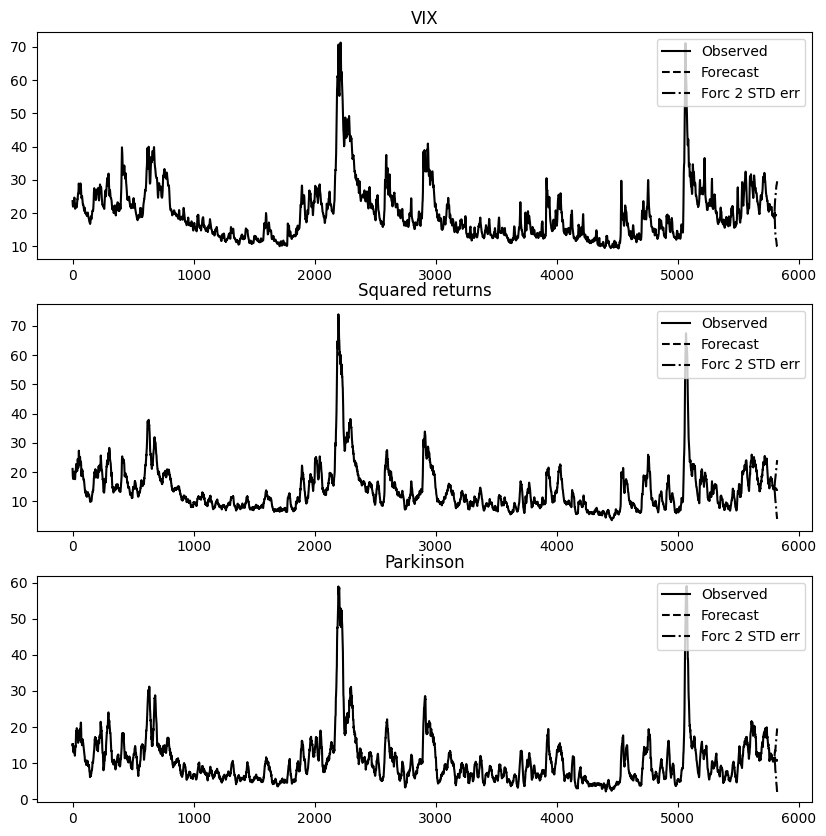

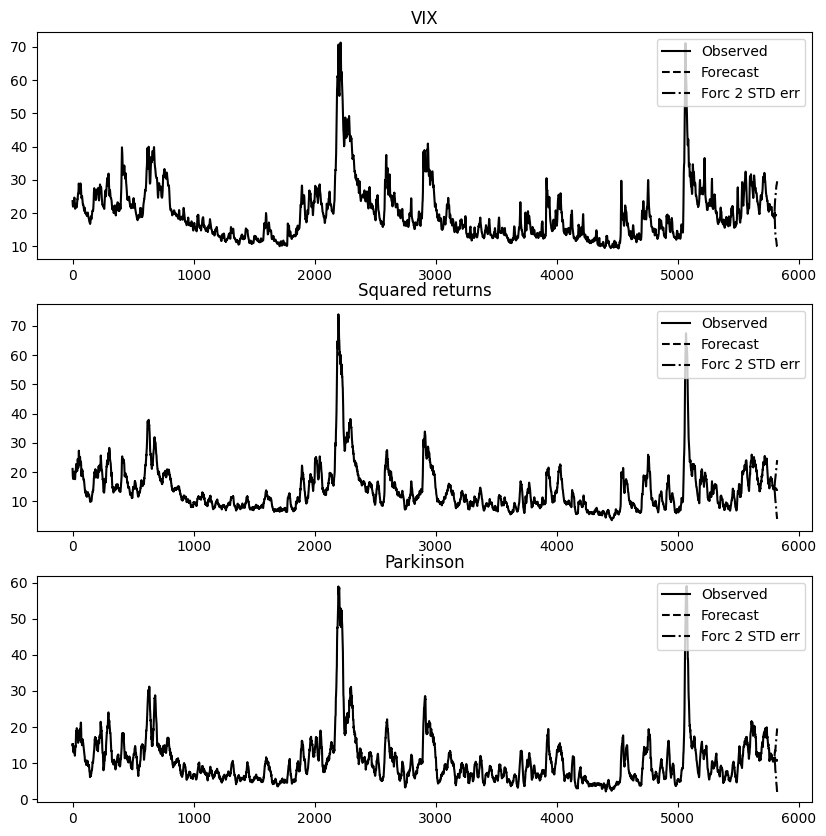

In [160]:
lag_order = 67
model_fitted = model.fit(67)
forecast_horiz = 22
model_fitted.forecast(df.values[-lag_order:], forecast_horiz)
model_fitted.plot_forecast(forecast_horiz)

In [161]:
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
import numpy as np

def grangers_test(data, maxlag, variables, test='ssr_chi2test',verbose=False):    
    """Les valeurs dans le df sont les p-valeurs
    L'hypothèse H0 de notre test est la suivant :
        "Les prédictions de la série X n'influence pas les prédictions de la série Y"
    Ce qui signifie qu'une p-valeur inférieure à 0.05 rejette l'hypothèse H0 et incite à garder ce couple de valeurs
    Comme on s'intéresse à la prédiciton de la variable 1, on ne va jamais l'abandonner
Les arguments sont :
    Data, le DF de nos valeurs
    maxlag, le fameux maxlag pour le nombre de paramètres dans l'équation'
    variables : une list qui contient le nom des variables c'est à dire le nom de nos colonnes'
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row, col]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)] #on va avoir toutes les p-valeurs une part lag
            min_p_value = np.min(p_values) #On s'intéresse à la valeur minimale des p-valeur
            df.loc[row, col] = min_p_value
    df.columns = [var + '_X' for var in variables]
    df.index = [var + '_Y' for var in variables]
    return df

In [162]:
grangers_test(df, 67, variables = df.columns)

,VIX_X,Squared returns_X,Parkinson_X
VIX_Y,1.0,0.0,0.0
Squared returns_Y,0.0,1.0,0.0
Parkinson_Y,0.0,0.0,1.0


### Interprétation de la fonction de réponse impulsionnelle 
- **Premièrement on remarque que les chocs se resorbent et tendent à revenir à 0, ce qui montre que les séries sont bien stationnaires**
- **On remarque qu'un choque sur la variable Squared returns à un impact positif sur les deux autres séries et ces chocs se resorbent environ après 30 jours**

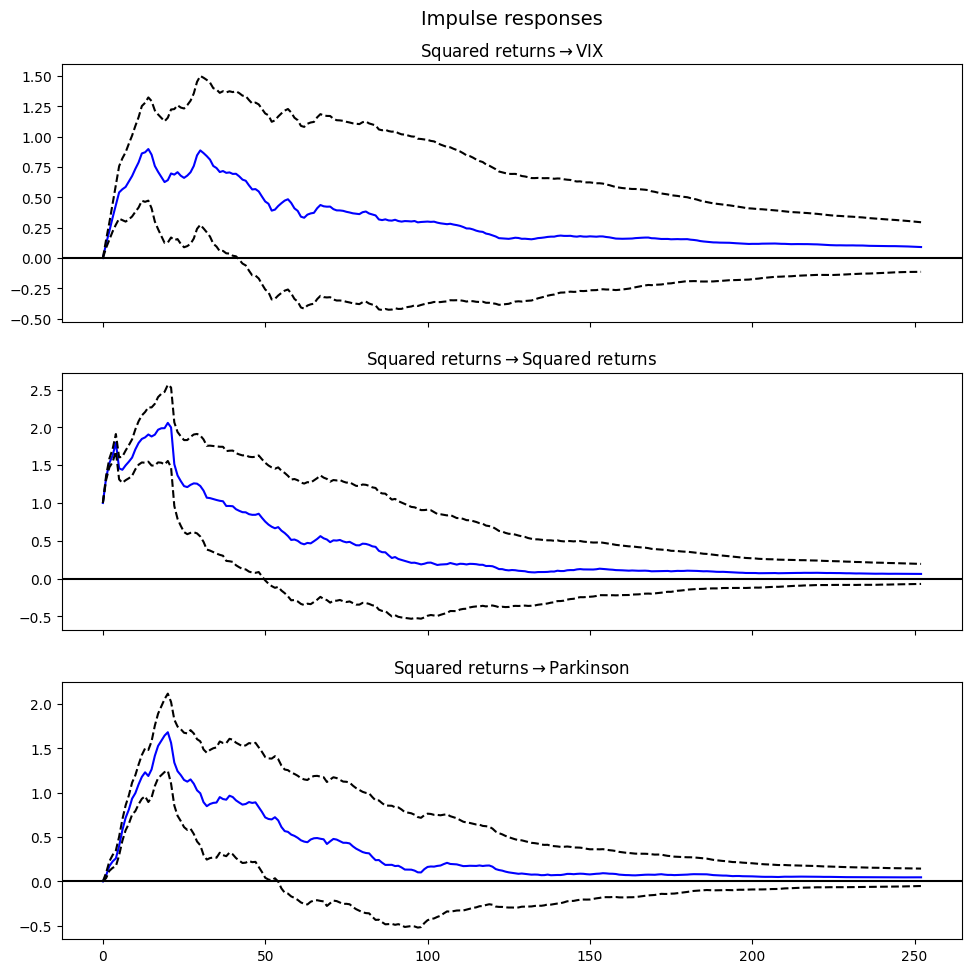

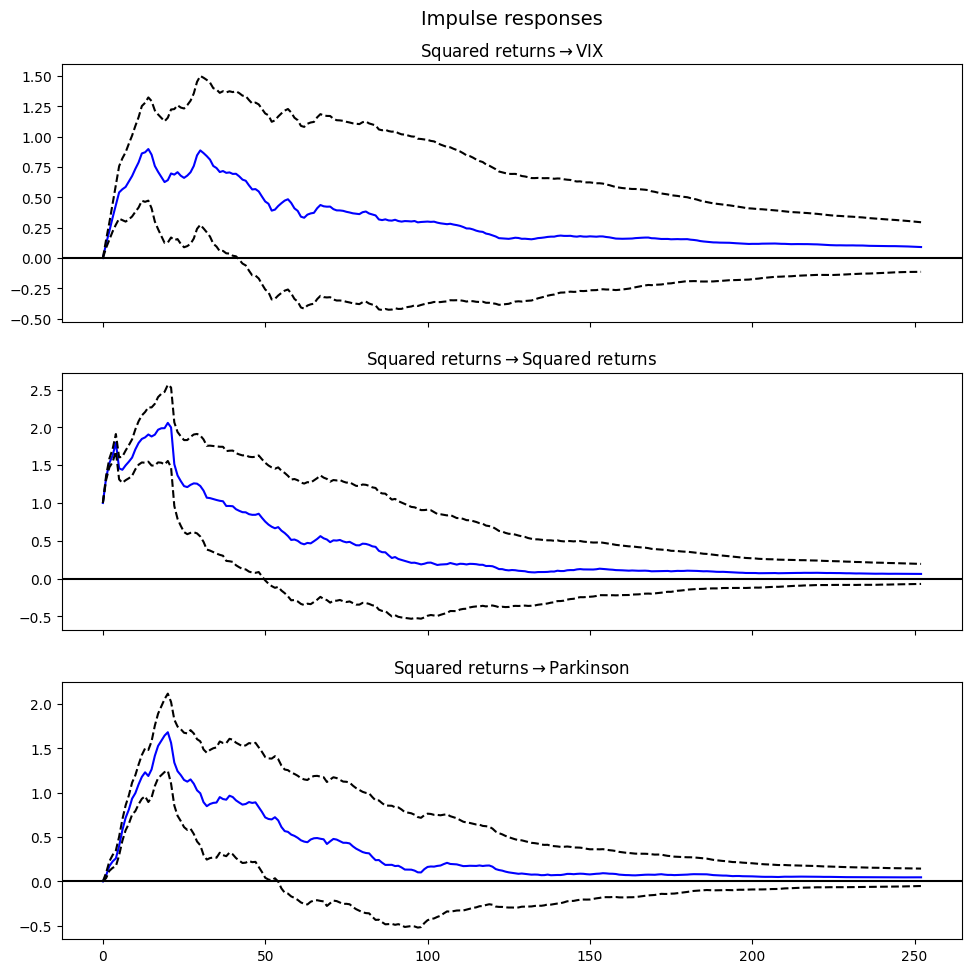

In [176]:
results.irf(252).plot(impulse=1)

### On peut regarder la qualité de prédiction du modèle à 1, 5 et 22 jours et on obtient de plutôt bons voir très bon résultats

In [165]:
import plotly.graph_objs as go
from sklearn.metrics import mean_absolute_percentage_error
# Calcul de la moyenne absolue de pourcentage d'erreur
def forcast_n_days(days:int):
    train = df.iloc[:-days,:]
    test = df.iloc[-days:,:]

    model = VAR(train)
    results = model.fit(maxlags=67)
    lag_order = results.k_ar
    fcst = results.forecast(train.values[-lag_order:], days)
    model_accuracy = 1 - mean_absolute_percentage_error(test, fcst)
    
    mape = mean_absolute_percentage_error(test, fcst)
    model_accuracy = 1 - mape
    print(model_accuracy)

    # Création des traces de données pour les prévisions et les vraies valeurs
    true_values_trace = go.Scatter(x=test.index, y=test.values[:, 0], name='True VIX')
    predictions_trace = go.Scatter(x=test.index, y=fcst[:, 0], name='Pred VIX')

    true_values_trace2 = go.Scatter(x=test.index, y=test.values[:, 1], name='True SQ')
    predictions_trace2 = go.Scatter(x=test.index, y=fcst[:, 1], name='Pred SQ')

    true_values_trace3 = go.Scatter(x=test.index, y=test.values[:, 2], name='True Parkinson')
    predictions_trace3 = go.Scatter(x=test.index, y=fcst[:, 2], name='Pred Parkinson')

    fig = go.Figure(data=[true_values_trace, predictions_trace,
                        true_values_trace2, predictions_trace2,
                        true_values_trace3, predictions_trace3])

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Values',
        title=f'MAPE: {np.round(mape*100, 2)}% - Model Accuracy: {np.round(model_accuracy*100, 2)}%',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    # Affichage de la figure
    fig.show()


In [167]:
forcast_n_days(1)

c:\Users\Zbook Create G7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



0.991224283001845


In [168]:
forcast_n_days(5)

0.9831683078914287


c:\Users\Zbook Create G7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [166]:
forcast_n_days(22)

c:\Users\Zbook Create G7\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



0.9624599858016719
